Code related to checking various vocab statistics

In [30]:
from vocabulary_functions import set_difference, set_intersection, get_mutated, get_parents
base_path = "/cta/share/users/mutbpe/tokenizers/blosum62/"

Count percentage of mutated tokens

In [31]:
import json
with open(base_path+"uniref50_mutbpe_0.8_3_12_0.005_51200.json") as f:
    vocab = json.load(f)
print(len(get_mutated(vocab))/ len(vocab))

0.8261319483765156


Check common tokens between two vocabs

In [32]:
import json
with open(base_path+"uniref50_mutbpe_0.8_3_12_0.005_51200.json") as f:
    vocab1 = json.load(f)
with open(base_path+"uniref50_bpe_51200.json") as f:
    vocab2 = json.load(f)
print(len(set_intersection(vocab1, vocab2)))

28255


Check the unique tokens in a vocab

In [33]:
import json
with open(base_path+"uniref50_mutbpe_0.8_3_12_0.005_51200.json") as f:
    vocab1 = json.load(f)
with open(base_path+"uniref50_bpe_51200.json") as f:
    vocab2 = json.load(f)
print(len(set_difference(vocab1, vocab2)))

22962


Check the utilization of unique tokens on a tokenized dataset

In [34]:
import sqlite3
import pandas as pd
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)
df_uniprot_human_seqs = pd.read_sql(f"SELECT Sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref50_distilled)", conn)
conn.close()
filtered_sequences = df_uniprot_human_seqs[
    (df_uniprot_human_seqs["Sequence"].str.count("X") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.count("B") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.count("U") <= 1) &
    (df_uniprot_human_seqs["Sequence"].str.count("Z") <= 1)
]["Sequence"].tolist()
filtered_sequences = df_uniprot_human_seqs["Sequence"].to_list()
print(len(filtered_sequences))


70901


In [35]:
from tokenizers import Tokenizer
from collections import Counter
from vocabulary_functions import calc_agreement
def token_usage_statistics(tokenizer1, tokenizer2, vocab1, vocab2, dataset):
    encoded1 = tokenizer1.encode_batch(dataset)
    t1_tokens = []
    for tlist in encoded1:
        t1_tokens.extend(tlist.tokens)
    encoded2 = tokenizer2.encode_batch(dataset)
    t2_tokens = []
    for tlist in encoded2:
        t2_tokens.extend(tlist.tokens)
    t1_counts = Counter(t1_tokens)
    t2_counts = Counter(t2_tokens)
    t1_uniques = set_difference(t1_counts, t2_counts)
    t2_uniques = set_difference(t2_counts, t1_counts)
    t1_total_count = len(t1_tokens)
    t2_total_count = len(t2_tokens)
    t1_total_unique_count = sum(t1_uniques.values())
    t2_total_unique_count = sum(t2_uniques.values())
    t1_usage = t1_total_unique_count/t1_total_count
    t2_usage = t2_total_unique_count/t2_total_count

    agreements = []
    for t1, t2 in zip(encoded1, encoded2):
        agreements.append(calc_agreement(t1.tokens, t2.tokens))
    return t1_usage, t2_usage, agreements

    

In [36]:
argument_set_cutoff = [0.7, 0.8, 0.9]
argument_set_mutfreq = [0, 0.005, 0.05]
vocab_size = 51200
dset = "uniref50pre"
tkzs = [
    Tokenizer.from_file(base_path + f"hf_{dset}_bpe_{vocab_size}.json")
]
labels = [
    "Standard"
]
for ct in argument_set_cutoff:
    for mf in argument_set_mutfreq:
        tkzs.append(
            Tokenizer.from_file(base_path + f"hf_{dset}_mutbpe_{ct}_3_12_{mf}_{vocab_size}.json")
        )
        labels.append(
            f"cutoff: {ct}\n freq_rate: {mf}"
        )

# Run the experiments for all combinations against the standard
vals1 = []
vals2 = []
agreement_data = []
for tkz in tkzs[1:]:
    v1, v2, agg = token_usage_statistics(tkzs[0], tkz, None, None, filtered_sequences)
    vals1.append(v1)
    vals2.append(v2)
    agreement_data.append(agg)



Plot the values

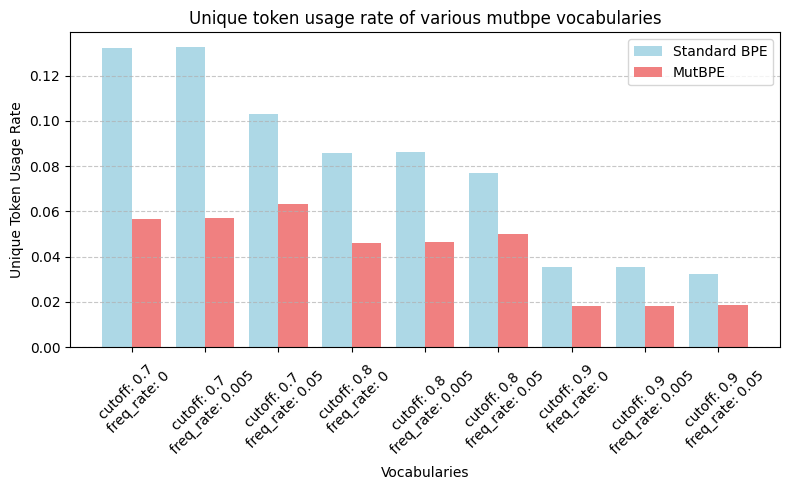

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = labels[1:]
# Bar width and positions
bar_width = 0.4
x = np.arange(len(x_labels))

# Plotting the double bar chart
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width / 2, vals1, width=bar_width, color='lightblue', label='Standard BPE')
plt.bar(x + bar_width / 2, vals2, width=bar_width, color='lightcoral', label='MutBPE')

# Adding labels and title
plt.xticks(x, x_labels, rotation=45)
plt.xlabel('Vocabularies')
plt.ylabel('Unique Token Usage Rate')
plt.title('Unique token usage rate of various mutbpe vocabularies')
plt.legend()

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Show the box chart of dice coefficients on various mutated vocabularies

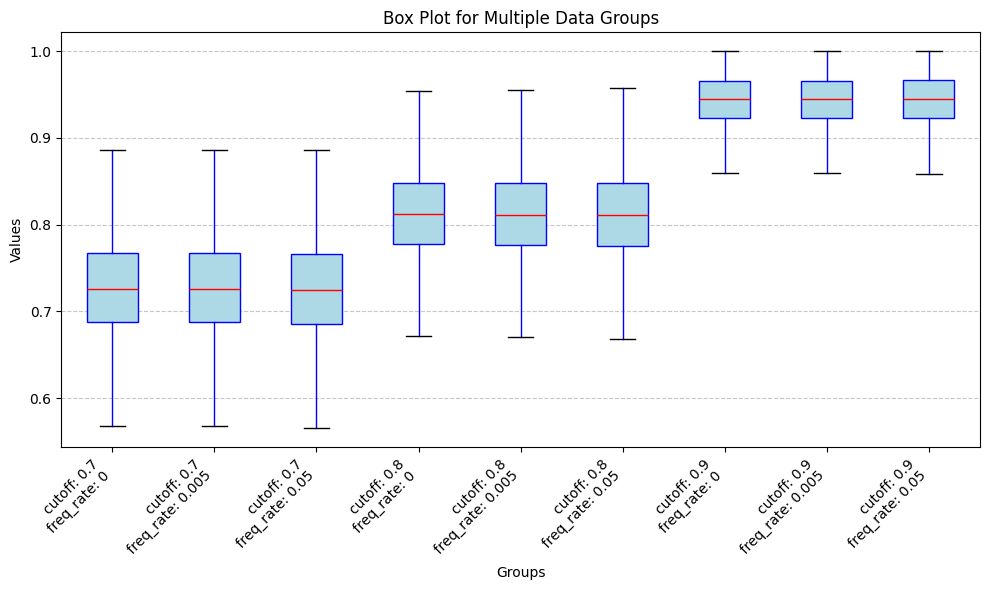

In [38]:
import numpy as np


# Labels for the box plots

# Creating the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(agreement_data, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'), whiskerprops=dict(color='blue'), showfliers=False)

# Customizing the plot
plt.xticks(ticks=np.arange(1, 10), labels=labels[1:], rotation=45, ha='right')
plt.xlabel('Groups')
plt.ylabel('Values')
plt.title('Box Plot for Multiple Data Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
